In [3]:
# Add annotations:
# TODO promoters 3kb 0.053
# TODO STR constraint
# TODO common SVs in ASD, known ASD genes
# TODO eSTRs q<0.05 0.0046 cat /storage/mgymrek/gtex/causality/GTEx_merged_causality.tab | awk '($6<0.05)' | awk '{print $2 "\t" $3 "\t" $3+1}' | sed 's/^chr//' | sed 's/\.0//' | grep -v best | grep -v NA | intersectBed -a /storage/mgymrek/ssc-denovos/denovos2/denovocalls_filtered/denovos_bylength.locus_summary.bed.gz -b stdin | awk '($6>0)' | uniq | datamash sum 8 sum 9 sum 13
# Top ones are promoters, AC dinucs

In [4]:
# scratch
import scipy.stats
#t = 783123
#n11 = 2211
#n21 = 2104
t = 26018
n11 = 73
n21 = 44
n12 = t-n11
n22 = t-n21
table = [[n11, n12], [n21, n22]]
scipy.stats.fisher_exact(table, alternative="greater")

(1.660945356435817, 0.0046309712487771163)

In [5]:
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import os
import pandas as pd
import scipy.stats

# Params
PTHRESH=0.8
PCOLORS = {
    "ALL": "black",
    1: "gray",
    2: "red",
    3: "gold",
    4: "blue",
    5: "green",
    6: "purple"
}
PLABELS = {
    "ALL": "ALL",
    1: "Mono-",
    2: "Di-",
    3: "Tri-",
    4: "Tetra-",
    5: "Penta-",
    6: "Hexa-"
}

# Load data
RESDIR="/storage/mgymrek/ssc-denovos/denovos2/denovocalls_filtered/"
data = pd.read_csv(os.path.join(RESDIR, "denovos_bylength.locus_summary.bed.gz"), sep="\t")
data = data[data["total_mutations"]>0]

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Figure 3A QQ plot

In [6]:
def GetPermP(x):
    t = x["total_children"]
    if x["total_mutations"] == 0:
        n_aff = 0
        n_unaff = 0
    else:
        nsample = x["total_mutations"]
        n_aff = np.random.hypergeometric(t/2, t/2, nsample)
        n_unaff = nsample - n_aff
    n11 = n_aff
    n12 = t - n_aff
    n21 = n_unaff
    n22 = t - n21
    table = [[n11, n12], [n21, n22]]
    return scipy.stats.fisher_exact(table, alternative="greater")[1]
    
data["perm_p"] = data.apply(GetPermP, 1)

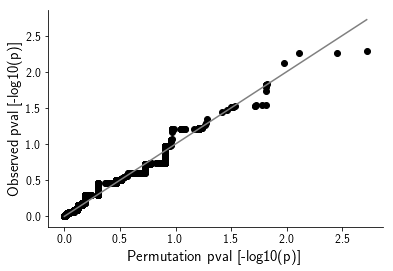

In [18]:
df = data
obs = [-1*np.log10(x) for x in sorted(list(df["p-value"]))]
exp = [-1*np.log10(x) for x in sorted(list(df["perm_p"]))]

maxval = max(obs + exp)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(exp, obs, color="black")
ax.plot([0,maxval],[0,maxval], color="gray")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Permutation pval [-log10(p)]", size=15)
ax.set_ylabel("Observed pval [-log10(p)]", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12);

# Figure 3B Enrichment by category

In [8]:
def GetASDEnrichment(df, printit=False):
    t = sum(df["total_children"])/2
    n11 = sum(df["affected_mutations"])
    n12 = t - n11
    n21 = sum(df["unaffected_mutations"])
    n22 = t - n21
    table = [[n11, n12], [n21, n22]]
    if printit:
        print(table)
    x = scipy.stats.fisher_exact(table, alternative="greater")
    return np.log2(x[0]), -1*np.log10(x[1])

In [9]:
motif_counts = data.groupby("motif", as_index=False).agg({"#chrom":len})
motif_counts.columns = ["motif","count"]
motif_counts = motif_counts.sort("count", ascending=False)
motifs = list(motif_counts[motif_counts["count"]>=50]["motif"].values)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [26]:
# Overall and by period
categories = ["ALL"]
odds, p = GetASDEnrichment(data)
pvals = [p]
enrichments = [odds]
colors = ["black"]
for period in range(1, 7):
    categories.append(PLABELS[period])
    odds, p = GetASDEnrichment(data[data["period"]==period])
    pvals.append(p)
    enrichments.append(odds)
    colors.append(PCOLORS[period])
# Coding
categories.append("Coding")
odds, p = GetASDEnrichment(data[data["coding"]>=1])
pvals.append(p)
enrichments.append(odds)
colors.append("white")
# Transcribed
categories.append("Transcribed")
odds, p = GetASDEnrichment(data[data["gene"]!="."])
pvals.append(p)
enrichments.append(odds)
colors.append("white")
for m in motifs:
    categories.append(m)
    odds, p = GetASDEnrichment(data[data["motif"]==m])
    pvals.append(p)
    enrichments.append(odds)
    colors.append("brown")
# STRCons Z TODO redo with new scores
categories.append("strconsZ")
odds, p = GetASDEnrichment(data[data.apply(lambda x: x["strconsZ"]!="." and float(x["strconsZ"])<0, 1)])
pvals.append(p)
enrichments.append(odds)
colors.append("cyan")

/usr/lib64/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


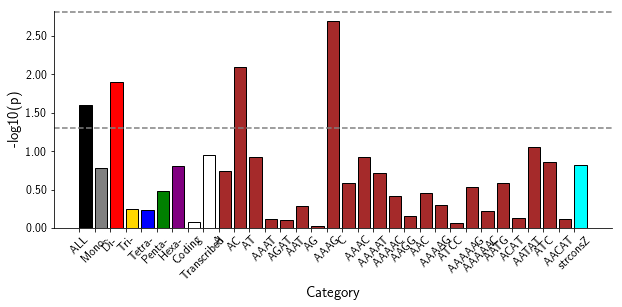

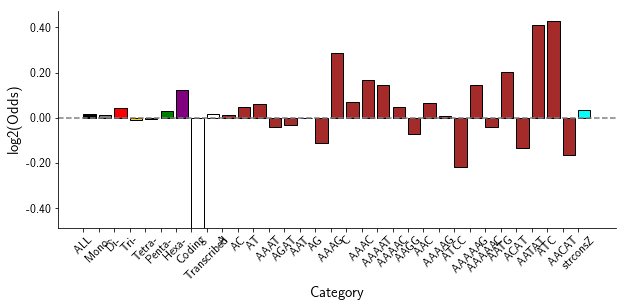

In [27]:
size = (10, 4)
fig = plt.figure()
fig.set_size_inches(size)
ax = fig.add_subplot(111)
ax.bar(range(len(categories)), pvals, color=colors, edgecolor="black", align="edge");
ax.axhline(-1*np.log10(0.05), color="gray", linestyle="dashed");
ax.axhline(-1*np.log10(0.05/len(categories)), color="gray", linestyle="dashed");
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Category", size=15)
ax.set_ylabel("-log10(p)", size=15)
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, size=12, rotation=45)
ax.set_yticklabels(["%0.2f"%x for x in ax.get_yticks()], size=12);
ax.legend(loc="upper right", frameon=False)

fig = plt.figure() 
fig.set_size_inches(size)
ax = fig.add_subplot(111)
ax.bar(range(len(categories)), enrichments, color=colors, edgecolor="black", align="edge");
ax.axhline(0, color="gray", linestyle="dashed");
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Category", size=15)
ax.set_ylabel("log2(Odds)", size=15)
#ax.set_ylim(bottom=-0.25, top=-0.25)
#ax.set_yticks(np.arange(-0.25, 0.26, 0.05))
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, size=12, rotation=45)
ax.set_yticklabels(["%0.2f"%(x) for x in ax.get_yticks()], size=12);

In [12]:
data[data["motif"]=="AAAG"].sort("p-value")

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,#chrom,start,end,period,total_children,total_mutations,total_mutation_rate,affected_children,affected_mutations,affected_new_mutations,...,p-value-new,children_with_mutations,coding,ExACmisZ,ExACpLI,gene,motif,strconsDIFF,strconsZ,perm_p
917156,12,79458707,79458779,4,550,5,0.009091,275,5,0,...,1.0,"14458:2:-4:177,187,376,13808:2:4:194,174,353,1...",0,.,.,SYT1,AAAG,.,.,0.500000
43114,1,78216310,78216372,4,572,7,0.012238,286,6,0,...,1.0,"14419:2:0:281,260,553,14364:1:4:130,135,261,13...",0,.,.,USP33,AAAG,.,.,0.774157
1269963,20,57039901,57039927,4,712,4,0.005618,356,4,0,...,1.0,"14571:2:2:14,14,22,13952:2:2:14,14,22,12363:2:...",0,1.23023629647237,0.0721886264777477,APCDD1L,AAAG,-1.329569996022713,-2.726425585619211,0.312236
1003772,14,46226464,46226509,4,886,4,0.004515,443,4,0,...,1.0,"13884:2:20:97,102,201,11855:2:28:27,30,47,1152...",0,.,.,.,AAAG,.,.,0.312288
190801,2,174327360,174327425,4,404,9,0.022277,202,7,0,...,1.0,"14697:2:0:111,112,222,14339:2:4:137,130,276,13...",0,.,.,.,AAAG,.,.,0.747320
89233,1,202903046,202903100,4,446,9,0.020179,223,7,0,...,1.0,"14591:2:23:36,38,66,14329:2:3:155,169,318,1396...",0,.,.,.,AAAG,2.482663062365082,0.9893144369164468,0.500000
852347,11,75641972,75642031,4,530,6,0.011321,265,5,0,...,1.0,"14031:2:12:152,156,298,13080:2:4:260,244,506,1...",0,0.905328196714655,0.754883919736062,UVRAG,AAAG,0.6275153907567596,0.2663395621671536,0.343306
898452,12,43428051,43428122,4,768,6,0.007812,384,5,0,...,1.0,"14696:2:0:73,83,166,14414:2:-12:187,192,407,13...",0,.,.,.,AAAG,.,.,0.343444
650936,8,36553390,36553461,4,786,6,0.007634,393,5,0,...,1.0,"14150:2:-4:170,203,377,14053:2:4:18,13,32,1402...",0,.,.,.,AAAG,.,.,0.656549
354519,4,87763940,87764030,4,288,3,0.010417,144,3,0,...,1.0,"13309:2:-4:9,9,15,12778:2:-8:11,14,27,11198:2:...",0,-0.82002267819405,1.10562988178488e-06,SLC10A6,AAAG,-0.5727922107825737,-0.22792866547646318,0.500000


In [13]:
edata = pd.DataFrame(
    {
        "category": categories,
        "pval": pvals,
        "enrich": enrichments
    }
)
edata.sort("pval", ascending=False)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,category,enrich,pval
16,AAAG,0.288169,2.696861
10,AC,0.049906,2.090434
2,Di-,0.041510,1.895044
0,ALL,0.018703,1.595942
29,AATAT,0.408150,1.057692
8,Transcribed,0.016695,0.944554
11,AT,0.059648,0.928581
18,AAAC,0.167878,0.925941
30,ATC,0.427971,0.862205
6,Hexa-,0.121695,0.803928
